In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats import pearsonr,spearmanr
###

import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler


%matplotlib inline

In [ ]:
import os
import numpy as np
import math


class SAX(object):
    """
    This class is for computing common things with the Symbolic
    Aggregate approXimation method.  In short, this translates
    a series of data to a string, which can then be compared with other
    such strings using a lookup table.
    """

    def __init__(self, wordSize = 8, alphabetSize = 7, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        #self.aOffset = ord('a')
        self.aOffset = 0
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        Function takes a series of data, x, and transforms it to a string representation
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt((len(x) * 1.0) / (self.wordSize * 1.0))
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        Function will normalize an array (give it a mean of 0, and a
        standard deviation of 1) unless it's standard deviation is below
        epsilon, in which case it returns an array of zeros the length
        of the original array.
        """
        X = np.asanyarray(x)
        if X.std() < self.eps:
            return [0 for entry in X]
        return (X-X.mean())/X.std()

    def to_PAA(self, x):
        """
        Funciton performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indicies corresponding to the original
        data for each reduced dimension
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        Converts the Piecewise Aggregate Approximation of x to a series of letters.
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if paaX[i] < self.beta[j]:
                    #alphabetizedX += chr(self.aOffset + j)
                    alphabetizedX += str(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += str(self.aOffset + len(self.beta))
        return alphabetizedX
    def compare_strings(self, sA, sB):
        """
        Compares two strings based on individual letter distance
        Requires that both strings are the same length
        """
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        Compare two letters based on letter distance return distance between
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        Builds up the lookup table to determine numeric distance between two letters
        given an alphabet size.  Entries for both 'ab' and 'ba' will be created
        and will have identical values.
        """

        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, cover, stride):
#        if not numSubsequences:
#            numSubsequences = 20
        self.windowSize = cover
        print(self.windowSize)
        #if not overlappingFraction:
        #    overlappingFraction = 0.9
        #overlap = self.windowSize*overlappingFraction
        moveSize = int(stride)
        print ('move'+str(moveSize))
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize

# Discretization

In [704]:
trainingTable= pd.read_csv('BATADAL_dataset03.csv')
testTable=pd.read_csv('BATADAL_dataset04.csv') #pd.read_csv('BATADAL_test_dataset.csv')
#dropping binary features
attFlagSerie = trainingTable.loc[:,["ATT_FLAG"]]
trainingTable = trainingTable.drop(columns=['ATT_FLAG','S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])


# converts datetime into Date format
trainingTable['DATETIME'] = pd.to_datetime(trainingTable['DATETIME'])
trainingTable= trainingTable.set_index('DATETIME')

testTable['DATETIME'] = pd.to_datetime(testTable['DATETIME'])
testTable= testTable.set_index('DATETIME')


In [705]:
normalized = {}
for serie in trainingTable:
    values = trainingTable[serie].values.reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(values)
    normalized[serie] = scaler.transform(values).flatten()

P_J415


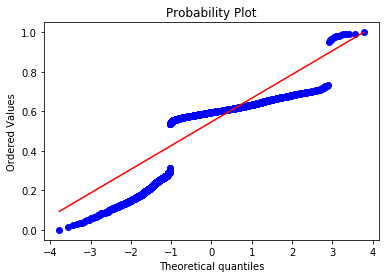

L_T7


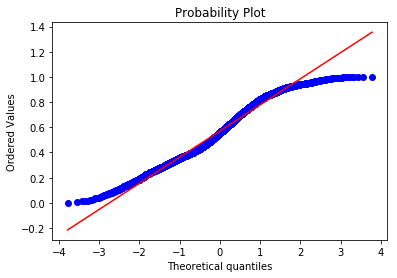

F_PU7


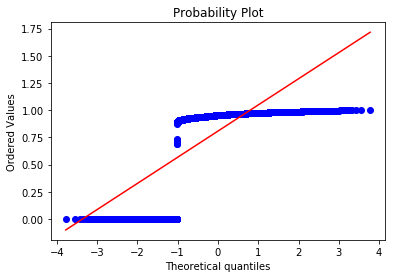

F_V2


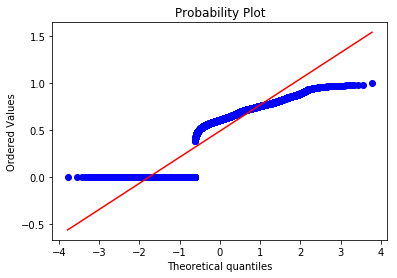

L_T4


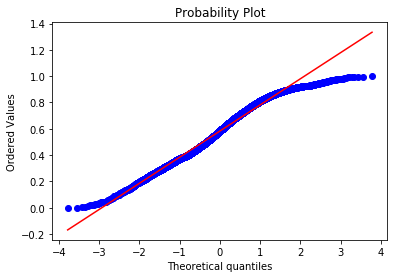

F_PU8


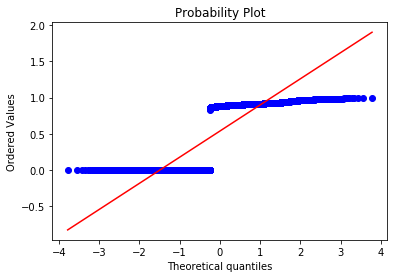

L_T1


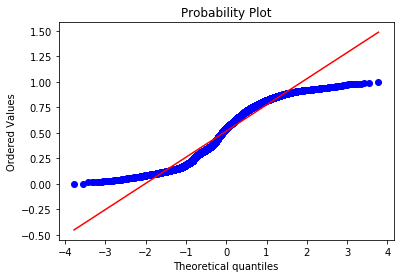

P_J306


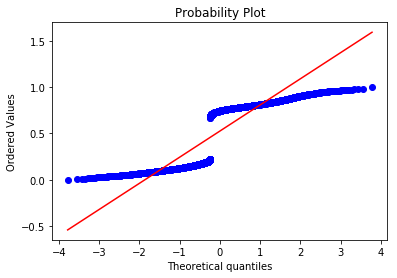

P_J256


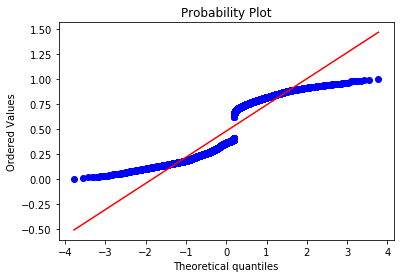

P_J317


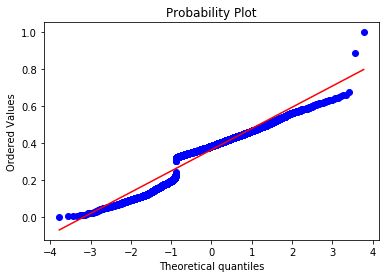

L_T6


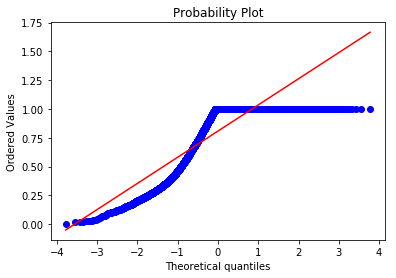

F_PU10


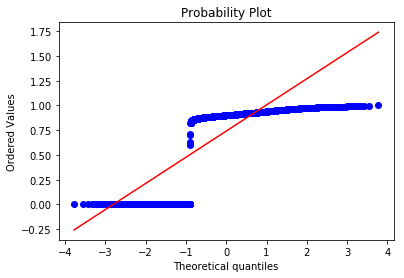

P_J269


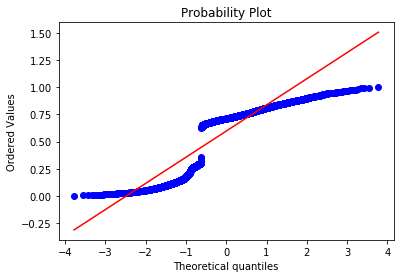

P_J280


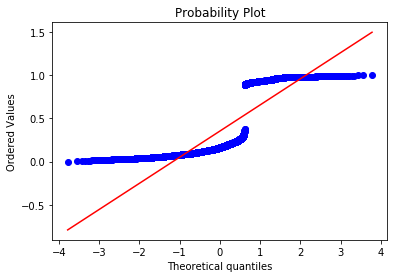

P_J302


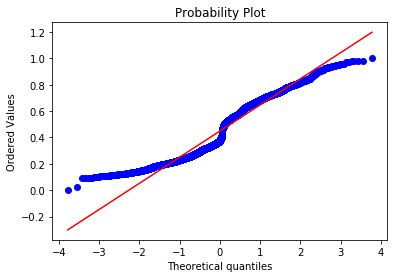

F_PU1


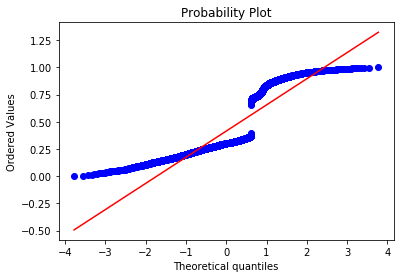

P_J14


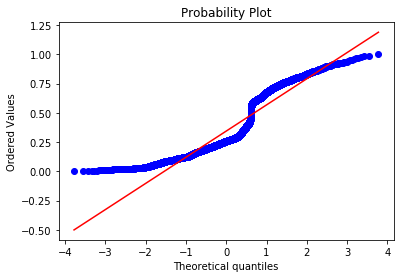

P_J300


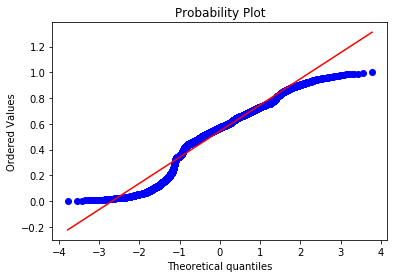

P_J422


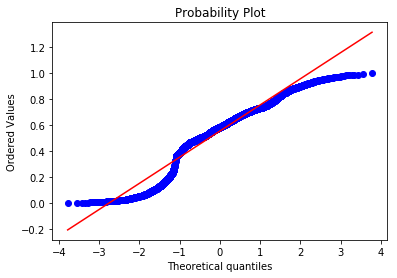

F_PU4


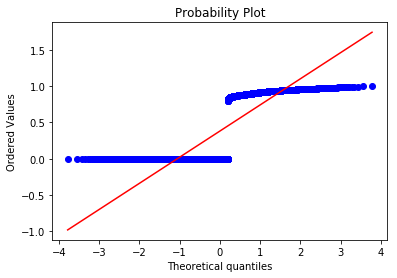

L_T2


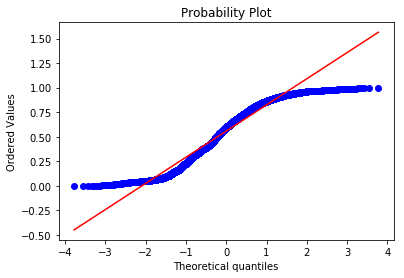

P_J289


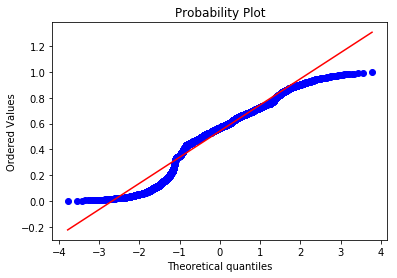

P_J307


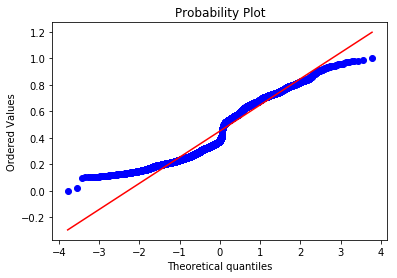

F_PU2


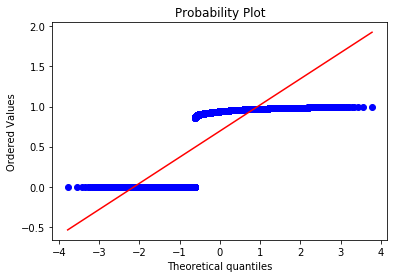

L_T5


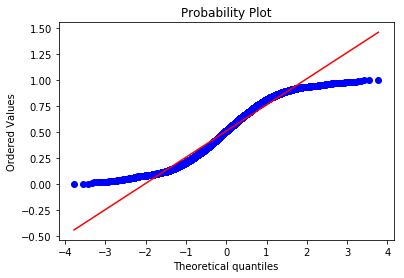

L_T3


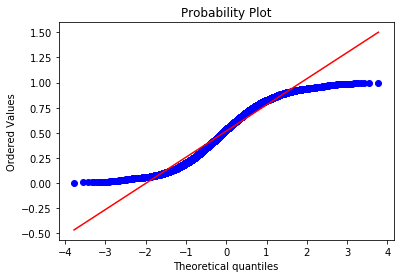

In [706]:
from scipy import stats
for serie in normalized:
    print(serie)
    res = stats.probplot(normalized[serie],plot=plt)
    if serie =="L_T4":
        plt.savefig("Prob_LT4")
    plt.show()
    

In [649]:
trainingTable.describe()

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU4,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,...,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,2.676905,3.285748,4.201820,3.568129,2.748205,5.370437,3.302672,100.926032,69.464357,14.555019,...,27.766451,79.411082,27.776600,82.737615,24.453808,74.459039,24.362250,67.921632,33.755911,29.453266
std,1.202940,1.468621,0.678465,0.539656,0.735162,0.177459,0.828849,10.048618,42.239742,17.042785,...,2.740755,8.461924,2.720291,7.502937,4.416089,9.974357,4.438203,5.321227,4.232716,2.658146
min,0.320112,0.293876,2.882847,2.002133,1.293241,4.824605,1.054194,85.495201,0.000000,0.000000,...,20.629910,65.059624,20.690191,54.757198,14.797167,58.325397,14.541955,51.697071,27.649677,22.370066
25%,1.650647,2.131776,3.623394,3.139640,2.123508,5.248147,2.631062,94.342598,0.000000,0.000000,...,26.656116,71.978676,26.674088,83.912292,20.516289,62.949253,20.409576,66.718307,30.668709,28.432796
50%,2.798855,3.498371,4.240439,3.574840,2.758198,5.500000,3.252838,96.729073,94.075195,0.000000,...,28.108925,75.879807,28.110842,85.219460,22.969397,81.176102,22.856150,68.807007,32.222023,29.834288
75%,3.754744,4.570782,4.793697,4.009889,3.372392,5.500000,3.986883,112.294952,96.614708,34.030491,...,29.552883,88.221329,29.553995,86.416519,28.457081,82.673698,28.382421,71.218712,38.134647,31.275637
max,4.871329,5.663802,5.433022,4.690665,4.162726,5.500000,4.999618,122.705627,100.140671,38.296165,...,33.763836,94.961258,33.763836,105.951820,36.325947,89.053986,36.325947,96.180450,45.388145,35.161724


In [650]:
series={}
for column in trainingTable:
    series[column] = trainingTable.loc[:,[column]]
    #serie_test = testTable.iloc[:,[0]]

# Calculate Sax for test and train

In [653]:
word_size=2920
alphabet_size = 9 
sax = SAX(word_size,alphabet_size)


In [682]:
word_size_test=1460
alphabet_size_test = 9 
sax_test = SAX(word_size_test,alphabet_size_test)


In [656]:
series_letters={}
for serie in series:
    (letters_str,indices)=sax.to_letter_rep(series[serie])
    series_letters[serie]=letters_str

In [677]:
(letters_test_str,indices_test)=sax_test.to_letter_rep(serie_test)
print(len(serie_test))
letters_test = list(letters_test_str)
letters_test = [ int(n) for n in letters_test]
print(letters_test)
print(indices_test)

4177
[6, 8, 5, 0, 0, 1, 1, 2, 4, 7, 6, 6, 8, 7, 3, 0, 0, 1, 5, 7, 7, 5, 8, 7, 2, 0, 2, 5, 6, 3, 5, 8, 6, 1, 1, 1, 2, 5, 7, 7, 6, 8, 4, 1, 0, 0, 0, 3, 7, 7, 5, 7, 8, 4, 1, 1, 5, 7, 5, 4, 7, 7, 2, 0, 2, 2, 3, 6, 7, 7, 8, 5, 2, 0, 0, 0, 1, 7, 5, 0, 0, 2, 5, 6, 5, 8, 7, 2, 0, 1, 1, 2, 4, 8, 5, 1, 0, 1, 5, 7, 6, 6, 8, 7, 1, 0, 2, 5, 6, 4, 6, 8, 5, 1, 2, 6, 7, 4, 6, 8, 6, 1, 0, 2, 6, 5, 4, 7, 8, 3, 0, 1, 2, 3, 6, 7, 3, 0, 0, 1, 6, 7, 6, 6, 8, 6, 0, 0, 1, 1, 2, 6, 7, 6, 6, 8, 6, 1, 1, 0, 3, 7, 7, 1, 1, 2, 3, 6, 7, 8, 7, 3, 0, 3, 7, 6, 4, 6, 8, 6, 1, 1, 1, 1, 4, 7, 7, 7, 7, 5, 1, 0, 0, 1, 6, 7, 2, 0, 1, 2, 4, 7, 8, 7, 3, 0, 0, 1, 1, 2, 6, 7, 6, 7, 7, 4, 1, 0, 0, 4, 7, 7, 4, 6, 8, 5, 0, 1, 3, 6, 5, 5, 8, 6, 1, 0, 1, 1, 2, 6, 7, 6, 7, 7, 4, 1, 1, 0, 3, 7, 6, 1, 0, 2, 6, 6, 5, 7, 7, 3, 0, 3, 7, 6, 4, 6, 8, 5, 0, 1, 3, 7, 3, 1, 2, 2, 4, 7, 8, 7, 8, 5, 2, 0, 0, 0, 3, 7, 5, 0, 1, 6, 7, 4, 5, 7, 8, 2, 1, 1, 2, 4, 7, 8, 7, 8, 7, 3, 0, 0, 0, 2, 6, 7, 6, 6, 8, 7, 1, 0, 4, 6, 5, 4, 6, 8, 5, 1, 2, 2, 3, 6

# Visualization of the discretized data

In [747]:
#L_T1 as example of visualization
serie = series['L_T1']
letters = list(series_letters['L_T1'])
letters = [ int(n) for n in letters]

In [748]:
#Some normalization for plotting
print(serie.max())
print(serie.min())

diff = serie.max()-serie.min()

print(diff/alphabet_size)
intervals = [serie.min()+i*diff/alphabet_size for i in range(alphabet_size)]
intervals = np.asarray(intervals).flatten()
intervals = [ i + diff/alphabet_size/2 for i in intervals]

L_T1    4.871329
dtype: float64
L_T1    0.320112
dtype: float64
L_T1    0.505691
dtype: float64


In [749]:
saxTable = []
for i in range(len(indices)):
    print(indices[i])
    for index in range(indices[i][0],indices[i][1]-1):
        saxTable.append(intervals[letters[i]])
       

(0, 4)
(3, 7)
(6, 10)
(9, 13)
(12, 16)
(15, 19)
(18, 22)
(21, 25)
(24, 28)
(27, 31)
(30, 34)
(33, 37)
(36, 40)
(39, 43)
(42, 46)
(45, 49)
(48, 52)
(51, 55)
(54, 58)
(57, 61)
(60, 64)
(63, 67)
(66, 70)
(69, 73)
(72, 76)
(75, 79)
(78, 82)
(81, 85)
(84, 88)
(87, 91)
(90, 94)
(93, 97)
(96, 100)
(99, 103)
(102, 106)
(105, 109)
(108, 112)
(111, 115)
(114, 118)
(117, 121)
(120, 124)
(123, 127)
(126, 130)
(129, 133)
(132, 136)
(135, 139)
(138, 142)
(141, 145)
(144, 148)
(147, 151)
(150, 154)
(153, 157)
(156, 160)
(159, 163)
(162, 166)
(165, 169)
(168, 172)
(171, 175)
(174, 178)
(177, 181)
(180, 184)
(183, 187)
(186, 190)
(189, 193)
(192, 196)
(195, 199)
(198, 202)
(201, 205)
(204, 208)
(207, 211)
(210, 214)
(213, 217)
(216, 220)
(219, 223)
(222, 226)
(225, 229)
(228, 232)
(231, 235)
(234, 238)
(237, 241)
(240, 244)
(243, 247)
(246, 250)
(249, 253)
(252, 256)
(255, 259)
(258, 262)
(261, 265)
(264, 268)
(267, 271)
(270, 274)
(273, 277)
(276, 280)
(279, 283)
(282, 286)
(285, 289)
(288, 292)
(291,

(8484, 8488)
(8487, 8491)
(8490, 8494)
(8493, 8497)
(8496, 8500)
(8499, 8503)
(8502, 8506)
(8505, 8509)
(8508, 8512)
(8511, 8515)
(8514, 8518)
(8517, 8521)
(8520, 8524)
(8523, 8527)
(8526, 8530)
(8529, 8533)
(8532, 8536)
(8535, 8539)
(8538, 8542)
(8541, 8545)
(8544, 8548)
(8547, 8551)
(8550, 8554)
(8553, 8557)
(8556, 8560)
(8559, 8563)
(8562, 8566)
(8565, 8569)
(8568, 8572)
(8571, 8575)
(8574, 8578)
(8577, 8581)
(8580, 8584)
(8583, 8587)
(8586, 8590)
(8589, 8593)
(8592, 8596)
(8595, 8599)
(8598, 8602)
(8601, 8605)
(8604, 8608)
(8607, 8611)
(8610, 8614)
(8613, 8617)
(8616, 8620)
(8619, 8623)
(8622, 8626)
(8625, 8629)
(8628, 8632)
(8631, 8635)
(8634, 8638)
(8637, 8641)
(8640, 8644)
(8643, 8647)
(8646, 8650)
(8649, 8653)
(8652, 8656)
(8655, 8659)
(8658, 8662)
(8661, 8665)
(8664, 8668)
(8667, 8671)
(8670, 8674)
(8673, 8677)
(8676, 8680)
(8679, 8683)
(8682, 8686)
(8685, 8689)
(8688, 8692)
(8691, 8695)
(8694, 8698)
(8697, 8701)
(8700, 8704)
(8703, 8707)
(8706, 8710)
(8709, 8713)
(8712, 8716)

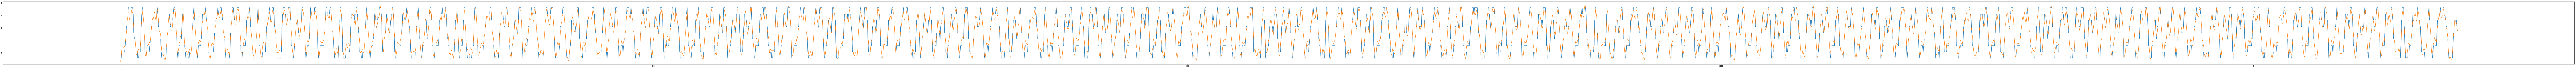

In [750]:
plt.figure(figsize=(300,7.5))
plt.plot(saxTable)
plt.plot(serie.values)
#plt.xlim(xmin=0,xmax=666)
plt.savefig('SAX L_T1.png')


In [678]:
print(serie_test.max())
print(serie_test.min())
diff_test = serie_test.max()-serie_test.min()
print(0.52+0.64666*alphabet_size_test)
print(diff_test/alphabet_size_test)
intervals_test = [serie_test.min()+i*diff_test/alphabet_size_test for i in range(alphabet_size_test)]
intervals_test = np.asarray(intervals_test).flatten()
intervals_test = [ i + diff_test/alphabet_size_test/2 for i in intervals_test]
print(intervals_test)

 L_T1    5.73
dtype: float64
 L_T1    0.32
dtype: float64
6.33994
 L_T1    0.601111
dtype: float64
[ L_T1    0.620556
dtype: float64,  L_T1    1.221667
dtype: float64,  L_T1    1.822778
dtype: float64,  L_T1    2.423889
dtype: float64,  L_T1    3.025
dtype: float64,  L_T1    3.626111
dtype: float64,  L_T1    4.227222
dtype: float64,  L_T1    4.828333
dtype: float64,  L_T1    5.429444
dtype: float64]


In [679]:
saxTable_test = []
x = 0
lastIndex = 0
for i in range(len(indices_test)):
    print(indices_test[i])
    if lastIndex!=indices_test[i][0]:
        print("mismatch")
        saxTable_test.append(intervals_test[letters_test[i]])
        
    for index in range(indices_test[i][0],indices_test[i][1]-1):
        print(index)
        lastIndex=index+1
        saxTable_test.append(intervals_test[letters_test[i]])

(0, 6)
0
1
2
3
4
(5, 11)
5
6
7
8
9
(11, 17)
mismatch
11
12
13
14
15
(17, 23)
mismatch
17
18
19
20
21
(22, 28)
22
23
24
25
26
(28, 34)
mismatch
28
29
30
31
32
(34, 40)
mismatch
34
35
36
37
38
(40, 46)
mismatch
40
41
42
43
44
(45, 51)
45
46
47
48
49
(51, 57)
mismatch
51
52
53
54
55
(57, 63)
mismatch
57
58
59
60
61
(62, 68)
62
63
64
65
66
(68, 74)
mismatch
68
69
70
71
72
(74, 80)
mismatch
74
75
76
77
78
(80, 86)
mismatch
80
81
82
83
84
(85, 91)
85
86
87
88
89
(91, 97)
mismatch
91
92
93
94
95
(97, 103)
mismatch
97
98
99
100
101
(102, 108)
102
103
104
105
106
(108, 114)
mismatch
108
109
110
111
112
(114, 120)
mismatch
114
115
116
117
118
(120, 126)
mismatch
120
121
122
123
124
(125, 131)
125
126
127
128
129
(131, 137)
mismatch
131
132
133
134
135
(137, 143)
mismatch
137
138
139
140
141
(143, 149)
mismatch
143
144
145
146
147
(148, 154)
148
149
150
151
152
(154, 160)
mismatch
154
155
156
157
158
(160, 166)
mismatch
160
161
162
163
164
(165, 171)
165
166
167
168
169
(171, 177)
mismatch
171
17

mismatch
2603
2604
2605
2606
2607
(2609, 2615)
mismatch
2609
2610
2611
2612
2613
(2614, 2620)
2614
2615
2616
2617
2618
(2620, 2626)
mismatch
2620
2621
2622
2623
2624
(2626, 2632)
mismatch
2626
2627
2628
2629
2630
(2632, 2638)
mismatch
2632
2633
2634
2635
2636
(2637, 2643)
2637
2638
2639
2640
2641
(2643, 2649)
mismatch
2643
2644
2645
2646
2647
(2649, 2655)
mismatch
2649
2650
2651
2652
2653
(2654, 2660)
2654
2655
2656
2657
2658
(2660, 2666)
mismatch
2660
2661
2662
2663
2664
(2666, 2672)
mismatch
2666
2667
2668
2669
2670
(2672, 2678)
mismatch
2672
2673
2674
2675
2676
(2677, 2683)
2677
2678
2679
2680
2681
(2683, 2689)
mismatch
2683
2684
2685
2686
2687
(2689, 2695)
mismatch
2689
2690
2691
2692
2693
(2695, 2701)
mismatch
2695
2696
2697
2698
2699
(2700, 2706)
2700
2701
2702
2703
2704
(2706, 2712)
mismatch
2706
2707
2708
2709
2710
(2712, 2718)
mismatch
2712
2713
2714
2715
2716
(2717, 2723)
2717
2718
2719
2720
2721
(2723, 2729)
mismatch
2723
2724
2725
2726
2727
(2729, 2735)
mismatch
2729
2730
2

In [680]:
print(serie_test)

                      L_T1
DATETIME                  
2016-04-07 00:00:00   2.44
2016-04-07 01:00:00   2.66
2016-04-07 02:00:00   3.11
2016-04-07 03:00:00   3.62
2016-04-07 04:00:00   4.08
2016-04-07 05:00:00   4.53
2016-04-07 06:00:00   4.84
2016-04-07 07:00:00   5.19
2016-04-07 08:00:00   5.22
2016-04-07 09:00:00   5.11
2016-04-07 10:00:00   4.73
2016-04-07 11:00:00   4.24
2016-04-07 12:00:00   3.74
2016-04-07 13:00:00   3.25
2016-04-07 14:00:00   2.70
2016-04-07 15:00:00   2.25
2016-04-07 16:00:00   1.93
2016-04-07 17:00:00   1.65
2016-04-07 18:00:00   1.43
2016-04-07 19:00:00   1.15
2016-04-07 20:00:00   0.93
2016-04-07 21:00:00   0.84
2016-04-07 22:00:00   0.70
2016-04-07 23:00:00   0.59
2016-05-07 00:00:00   0.49
2016-05-07 01:00:00   0.35
2016-05-07 02:00:00   0.32
2016-05-07 03:00:00   0.44
2016-05-07 04:00:00   0.70
2016-05-07 05:00:00   0.93
...                    ...
2016-12-23 19:00:00   3.56
2016-12-23 20:00:00   3.35
2016-12-23 21:00:00   3.19
2016-12-23 22:00:00   2.96
2

4176
4177


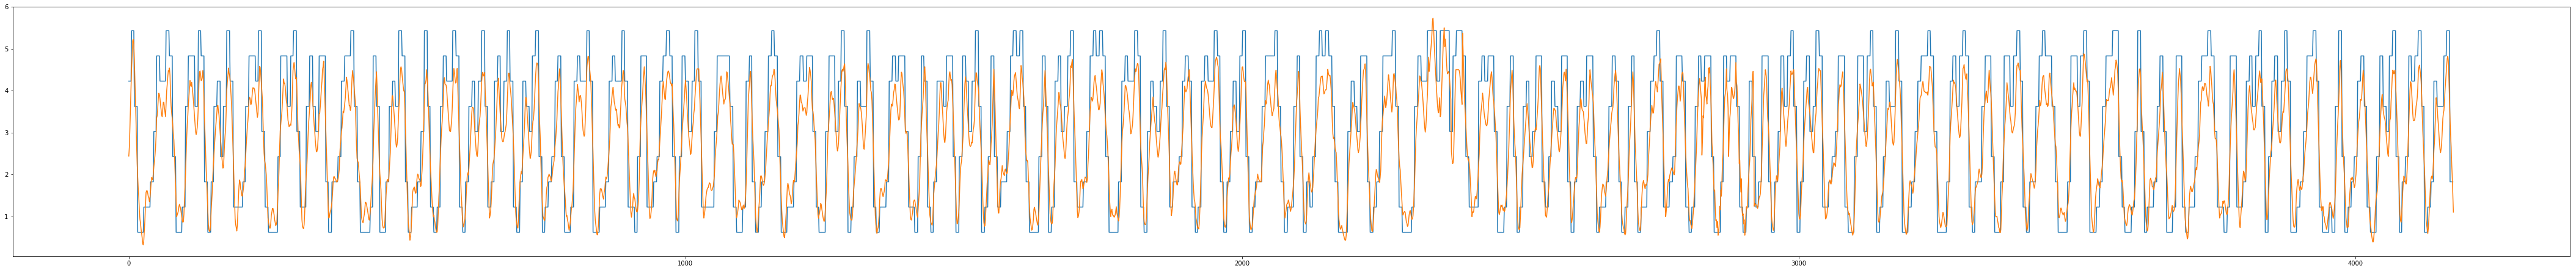

In [681]:
plt.figure(figsize=(75,7.5))
print(len(saxTable_test))
print(len(serie_test.values))
plt.plot(saxTable_test)
plt.plot(serie_test.values)


# N-gram Handling

In [713]:
from nltk.util import ngrams
from nltk.util import everygrams

In [708]:
nltk.usage()

AttributeError: module 'nltk.stem.util' has no attribute 'usage'

In [977]:
series_letters['L_T1']

'001111235787778874310010015786300121123577777787543100000024676546788741012335762100001001578631012223577787641000111246778778876431000001468876678886200122236778753100013686200011113567876788753100000157887667888620012466543468875101223687777887410122222468877788643100100268751000111112577776787541001001578631011235765677887311346764456787410011112457776787653101000157863101224664357886200112223677877787532000000136773101223685210001100268862000111124577777886421000001467776568875200123566446888620011223577787788743100010014688766788863100111256788631000023676445688631001111356777778875410000014687410136777545788620012212347888778764310010014678765788853101357765457887410123323567877787653100000147852000121246778631000135777656888620002357754688752001235665457877410135776445688631012222467788788753201010015785300123577656888620012222357787778864310000013678765788863100235675468876200011112357777678754100000146787656888631012356654688762001111224677788741122223567877788764200100146774

In [978]:
n_grams_test= {}
for i in range(3,6):
    n_gram_size =i
    n_grams_test[i] = [ letters_test_str[i:i+n_gram_size] for i in range(len(letters_test_str)-n_gram_size)]
n_grams_test

{3: ['685',
  '850',
  '500',
  '001',
  '011',
  '112',
  '124',
  '247',
  '476',
  '766',
  '668',
  '687',
  '873',
  '730',
  '300',
  '001',
  '015',
  '157',
  '577',
  '775',
  '758',
  '587',
  '872',
  '720',
  '202',
  '025',
  '256',
  '563',
  '635',
  '358',
  '586',
  '861',
  '611',
  '111',
  '112',
  '125',
  '257',
  '577',
  '776',
  '768',
  '684',
  '841',
  '410',
  '100',
  '000',
  '003',
  '037',
  '377',
  '775',
  '757',
  '578',
  '784',
  '841',
  '411',
  '115',
  '157',
  '575',
  '754',
  '547',
  '477',
  '772',
  '720',
  '202',
  '022',
  '223',
  '236',
  '367',
  '677',
  '778',
  '785',
  '852',
  '520',
  '200',
  '000',
  '001',
  '017',
  '175',
  '750',
  '500',
  '002',
  '025',
  '256',
  '565',
  '658',
  '587',
  '872',
  '720',
  '201',
  '011',
  '112',
  '124',
  '248',
  '485',
  '851',
  '510',
  '101',
  '015',
  '157',
  '576',
  '766',
  '668',
  '687',
  '871',
  '710',
  '102',
  '025',
  '256',
  '564',
  '646',
  '468',
  '685'

# n-gram LM 

P(w1|w2) = c(w1,w2)/c(w2)

In [979]:
probabilities ={}
def key(i,j):
    return str(i)+str(j)

#print(probabilities)
for i in range(alphabet_size):
    for j in range(alphabet_size):
        probabilities[key(i,j)]=series_letters['L_T4'].count(key(i,j))
print(probabilities)
#LAPLACE Smothing
for i in range(alphabet_size):
    for j in range(alphabet_size):
        probabilities[key(i,j)]+=1
print("\n")
print(probabilities)
for i in range(alphabet_size):
    for j in range(alphabet_size):
#        print(probabilities[i])
        probabilities[key(i,j)]/=series_letters['L_T4'].count(str(i))
print(sorted(probabilities.items()))

{'08': 0, '78': 16, '36': 65, '47': 62, '51': 30, '82': 5, '17': 0, '02': 37, '23': 25, '26': 62, '42': 23, '81': 1, '88': 7, '72': 33, '71': 16, '61': 28, '74': 40, '37': 34, '87': 13, '06': 9, '25': 65, '65': 139, '68': 19, '63': 48, '53': 65, '15': 62, '32': 25, '27': 8, '18': 0, '45': 65, '62': 38, '44': 33, '24': 26, '64': 58, '48': 8, '85': 9, '67': 54, '16': 17, '21': 37, '03': 18, '40': 23, '60': 11, '70': 6, '86': 8, '80': 0, '00': 53, '07': 0, '10': 35, '28': 0, '50': 30, '56': 123, '83': 11, '20': 25, '14': 30, '52': 48, '66': 89, '76': 44, '55': 157, '58': 15, '13': 44, '34': 29, '54': 99, '84': 13, '41': 29, '22': 29, '12': 39, '77': 40, '01': 60, '05': 15, '11': 31, '33': 18, '04': 11, '73': 37, '57': 79, '31': 26, '35': 76, '75': 58, '38': 2, '30': 20, '46': 67, '43': 29}


{'08': 1, '78': 17, '36': 66, '47': 63, '51': 31, '82': 6, '17': 1, '02': 38, '23': 26, '26': 63, '42': 24, '81': 2, '88': 8, '72': 34, '71': 17, '61': 29, '74': 41, '37': 35, '87': 14, '06': 10, '25'

In [980]:
probabilities.update({k: np.log10(v) for k, v in probabilities.items()})

In [981]:
from nltk import ngrams
x = everygrams(series_letters['L_T4'],min_len=2,max_len=5)

In [982]:
letters_test_str

'6850011247668730015775872025635861112577684100037757841157547720223677852000175002565872011248510157668710256468512674686102654783012367300167668600112676686110377112367873037646861111477775100167201247873001126767741004774685013655861011267677411037610266577303764685013731224787852000375016745782112478787300026766871046546851223676101676687202464783012257778520115730213787875200046547720124777851000157668886888478873111676774001573015634772136547720256577301125762015720114678611237761015767730027677510163127720247578502674587112347710037747850136558600124677874000267578710225773002775786102257877520002775786001257788310014840112574001771011367787411017711267578503674686001247786100105830123675100375478302376785012655782'

In [983]:
n=6
testGrams =[''.join(gram) for gram in list(ngrams(letters_test_str, n))]

In [984]:
def calculateProbability(ngram, model, modelN):
    if len(ngram)<modelN:
        raise tooLittleN("ngram smaller than model ngrams")
    parts = ngrams(ngram,modelN)
    probability=0
    for part in parts:
        string = ''.join(part)
        print(string + ": "+str(model[string]))
        probability+=model[string]
    return probability

In [985]:
testProbabilities = {}
for ngram in testGrams:
    testProbabilities[ngram]=calculateProbability(ngram,probabilities,2)

68: -1.3926969532596658
85: -0.8260748027008264
50: -1.3340644239335504
00: -0.5959858436157692
01: -0.5430497684279707
85: -0.8260748027008264
50: -1.3340644239335504
00: -0.5959858436157692
01: -0.5430497684279707
11: -0.9180958956169019
50: -1.3340644239335504
00: -0.5959858436157692
01: -0.5430497684279707
11: -0.9180958956169019
12: -0.8211858826088455
00: -0.5959858436157692
01: -0.5430497684279707
11: -0.9180958956169019
12: -0.8211858826088455
24: -1.0126810317590889
01: -0.5430497684279707
11: -0.9180958956169019
12: -0.8211858826088455
24: -1.0126810317590889
47: -0.7346855566025534
11: -0.9180958956169019
12: -0.8211858826088455
24: -1.0126810317590889
47: -0.7346855566025534
76: -0.8180791972835949
12: -0.8211858826088455
24: -1.0126810317590889
47: -0.7346855566025534
76: -0.8180791972835949
66: -0.7394844394843221
24: -1.0126810317590889
47: -0.7346855566025534
76: -0.8180791972835949
66: -0.7394844394843221
68: -1.3926969532596658
47: -0.7346855566025534
76: -0.818079197

67: -0.9533642594294031
77: -0.8585078543392031
75: -0.7004396994167944
51: -1.3340644239335504
67: -0.9533642594294031
77: -0.8585078543392031
75: -0.7004396994167944
51: -1.3340644239335504
10: -0.8669433731695206
77: -0.8585078543392031
75: -0.7004396994167944
51: -1.3340644239335504
10: -0.8669433731695206
01: -0.5430497684279707
75: -0.7004396994167944
51: -1.3340644239335504
10: -0.8669433731695206
01: -0.5430497684279707
16: -1.167973368833502
51: -1.3340644239335504
10: -0.8669433731695206
01: -0.5430497684279707
16: -1.167973368833502
63: -1.0035308688951332
10: -0.8669433731695206
01: -0.5430497684279707
16: -1.167973368833502
63: -1.0035308688951332
31: -1.0399279468999514
01: -0.5430497684279707
16: -1.167973368833502
63: -1.0035308688951332
31: -1.0399279468999514
12: -0.8211858826088455
16: -1.167973368833502
63: -1.0035308688951332
31: -1.0399279468999514
12: -0.8211858826088455
27: -1.4898022864787515
63: -1.0035308688951332
31: -1.0399279468999514
12: -0.82118588260884

In [986]:
testProbabilities

{'000157': -3.2812629109186147,
 '000175': -4.858707029013111,
 '000267': -3.5386361999473634,
 '000277': -4.28887783487142,
 '000375': -3.869261055842905,
 '000377': -4.027329210765314,
 '000465': -3.690286151217959,
 '001058': -4.751544741107971,
 '001124': -3.890998422028576,
 '001126': -3.5230216367339815,
 '001246': -3.674419719761573,
 '001247': -3.707588083014228,
 '001257': -3.5070584858046727,
 '001484': -4.330650155785674,
 '001573': -3.576785181744974,
 '001576': -3.5033562645864404,
 '001577': -3.5437849216420485,
 '001672': -4.200186034323329,
 '001676': -4.07845243759024,
 '001750': -5.596785609330892,
 '001771': -5.661632130000416,
 '002565': -3.2486860566649014,
 '002675': -3.643090055748389,
 '002676': -3.7607295536151892,
 '002767': -4.605827593629447,
 '002775': -4.393331690672445,
 '003750': -4.6073396361606855,
 '003754': -4.098701329994959,
 '003774': -4.289851221488747,
 '003775': -4.131783066566338,
 '004654': -3.919726425370013,
 '004774': -4.296885466287842,
 

In [987]:
def isAnomaly(threshold,value):
    if value<threshold:
        return "anomaly"
    return "valid"

In [988]:
threshold = -5.2
d2= dict((k, isAnomaly(threshold,v)) for k, v in testProbabilities.items())

In [989]:
valid_set=[d2[letters_test_str[i:i+n]] for i in range(len(letters_test_str)-n)]
letterToOriginalSizeRatio = int(len(testTable.iloc[:,[-1]])/len(letters_test_str))
anomalies=[]
TP =0
FP = 0
for i,x in enumerate(valid_set):
    if x=="anomaly":
        #print(i)
        anomalies.append(i)

print(len(anomalies))
for anomaly in anomalies:
    minbound = (anomaly*letterToOriginalSizeRatio)-int(letterToOriginalSizeRatio/2)
    if (minbound<0):
        minbound==0
    maxbound = (anomaly*letterToOriginalSizeRatio)+int(letterToOriginalSizeRatio/2)
    if maxbound>=len(testTable.iloc[:,[-1]]):
        maxbound = len(testTable.iloc[:,[-1]])-1
    if (1 in testTable.iloc[:,[-1]][minbound:maxbound].values):
        print("TP")
        TP+=1
    else:
        FP+=1

40
TP
